# Timeseries anomaly detection using an Autoencoder

**Author:** [pavithrasv](https://github.com/pavithrasv)<br>
**Date created:** 2020/05/31<br>
**Last modified:** 2020/05/31<br>
**Description:** Detect anomalies in a timeseries using an Autoencoder.

## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

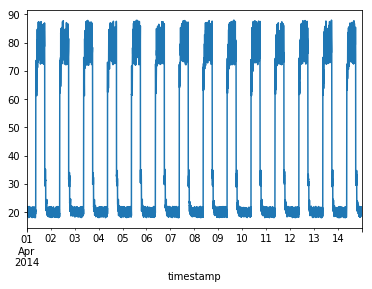

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

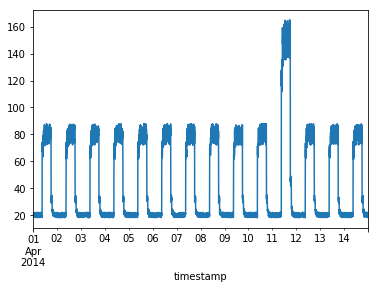

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [90]:

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [91]:
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [92]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [93]:
class Conv1DTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid', activation="relu"):
        super().__init__()
        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, activation=activation
        )

    def call(self, x):
        x = tf.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tf.squeeze(x, axis=2)
        return x

In [94]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 144, 32)           256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 144, 32)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_17 (Conv1DT (None, 144, 16)           1808      
_________________________________________________________________
dropout_17 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_18 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_19 (Conv1DT (None, 288, 1)           

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [95]:
x_train.shape

(3744, 288, 1)

In [22]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 53ms/step - loss: 0.6594 - val_loss: 0.4275
Epoch 2/50
27/27 [==============================] - 1s 45ms/step - loss: 0.4195 - val_loss: 0.4016
Epoch 3/50
27/27 [==============================] - 1s 44ms/step - loss: 0.4070 - val_loss: 0.3982
Epoch 4/50
27/27 [==============================] - 1s 51ms/step - loss: 0.4013 - val_loss: 0.3946
Epoch 5/50
27/27 [==============================] - 1s 46ms/step - loss: 0.3971 - val_loss: 0.3931
Epoch 6/50
27/27 [==============================] - 1s 43ms/step - loss: 0.3941 - val_loss: 0.3925
Epoch 7/50
27/27 [==============================] - 1s 43ms/step - loss: 0.3918 - val_loss: 0.3913
Epoch 8/50
27/27 [==============================] - 1s 46ms/step - loss: 0.3902 - val_loss: 0.3916
Epoch 9/50
27/27 [==============================] - 1s 51ms/step - loss: 0.3888 - val_loss: 0.3911
Epoch 10/50
27/27 [==============================] - 1s 49ms/step - loss: 0.3878 - val_loss: 0.3907
Epoch 11/

Let's plot training and validation loss to see how the training went.

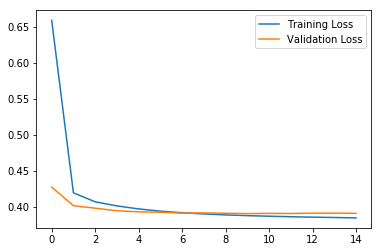

In [23]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


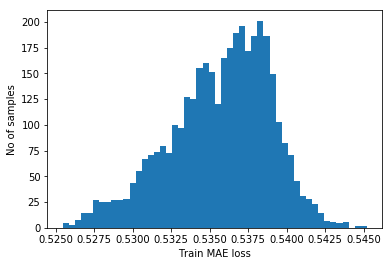

Reconstruction error threshold:  0.5452004561878107


In [24]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

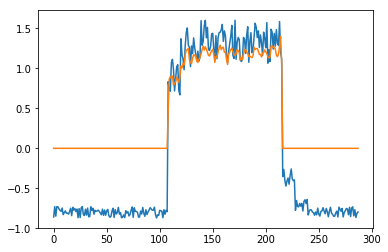

In [25]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

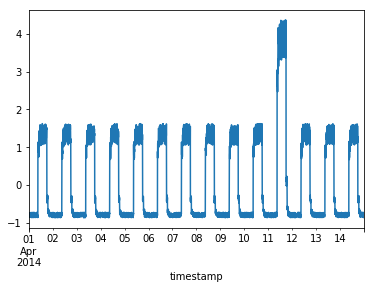

Test input shape:  (3744, 288, 1)


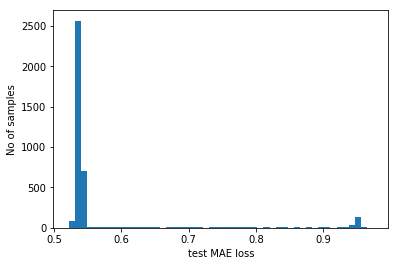

Number of anomaly samples:  412
Indices of anomaly samples:  (array([ 781,  782,  785,  789,  790,  794,  970,  978, 1646, 1653, 1654,
       1655, 1657, 1658, 1659, 2517, 2519, 2522, 2523, 2698, 2701, 2702,
       2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713,
       2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724,
       2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735,
       2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746,
       2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757,
       2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768,
       2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779,
       2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790,
       2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801,
       2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812,
       2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2

In [26]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [27]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

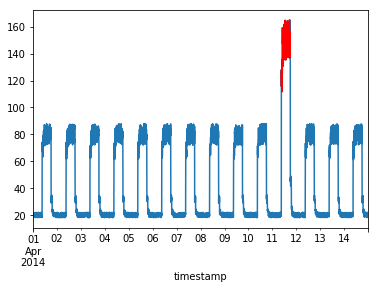

In [28]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [628]:
df = pd.DataFrame()
df['x'] = np.arange(0,1000)
df['y'] = 0.002 * df['x'] + 5 + np.random.normal(0,0.3,size=1000)

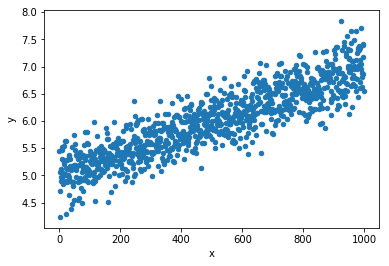

In [629]:
df.plot(kind='scatter', x= 'x', y='y')

In [630]:
def anomaly(x):
    if x < 400:
        return 0.002 * x + 5
    else:
        return 0.002 * x + 6
        #return 0.002 * 400 + 0.008 * (x - 400) + 5

In [631]:
df_anom = pd.DataFrame()
df_anom['x'] = np.arange(0,1000)
df_anom['y'] = df_anom['x'].apply(lambda x : anomaly(x)) + np.random.normal(0,0.3,size=1000)

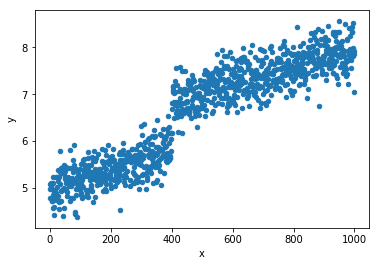

In [632]:
df_anom.plot(kind='scatter', x= 'x', y='y')

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [633]:

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df['y'].mean()
training_std = df['y'].std()
df_training_value = (df['y'] - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 1000


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [634]:
TIME_STEPS = 50

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (950, 50)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [635]:
model = keras.Sequential(
    [
        layers.Dense(32, input_shape=(x_train.shape[1],)),
        layers.Dropout(rate=0.2),
        #layers.Dense(8),
        layers.Dense(8),
        #layers.Dense(8),
        layers.Dropout(rate=0.2),
        layers.Dense(32),
        layers.Dense(x_train.shape[1])
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 32)                1632      
_________________________________________________________________
dropout_100 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 8)                 264       
_________________________________________________________________
dropout_101 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_146 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_147 (Dense)            (None, 50)                1650      
Total params: 3,834
Trainable params: 3,834
Non-trainable params: 0
___________________________________________________

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [636]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
7/7 [==============================] - 0s 15ms/step - loss: 1.2646 - val_loss: 2.0132
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8406 - val_loss: 1.5539
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.7219 - val_loss: 1.2803
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6202 - val_loss: 0.9767
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.5269 - val_loss: 0.7334
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 0.4668 - val_loss: 0.5896
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 0.4063 - val_loss: 0.5459
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3775 - val_loss: 0.4483
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3624 - val_loss: 0.3945
Epoch 10/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3453 - val_loss: 0.4176
Epoch 11/50
7/7 [=====================

Let's plot training and validation loss to see how the training went.

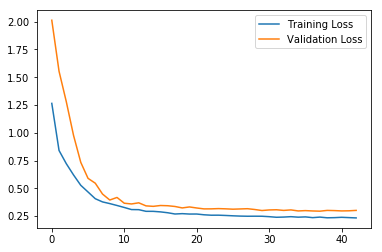

In [637]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


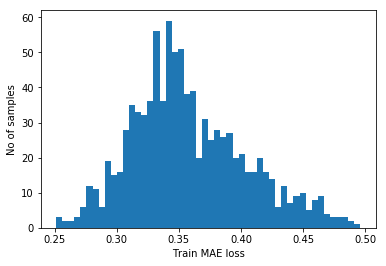

Reconstruction error threshold:  0.4961193565460462


In [638]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

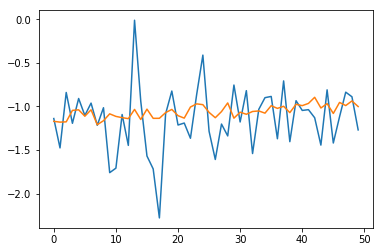

In [639]:
# Checking how the first sequence is learnt
plt.plot(x_train[100])
plt.plot(x_train_pred[100])
plt.show()

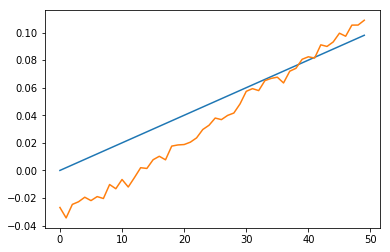

In [640]:
x_fake = np.arange(0,50).reshape(1,-1)*0.002
x_fake_pred = model.predict(x_fake)
# Checking how the first sequence is learnt
plt.plot(x_fake[0])
plt.plot(x_fake_pred[0])
plt.show()

### Prepare test data

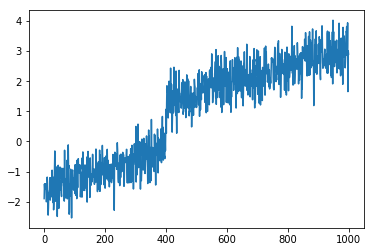

Test input shape:  (950, 50)


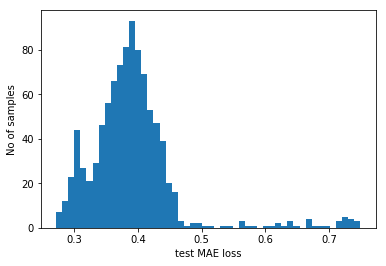

Number of anomaly samples:  41
Indices of anomaly samples:  (array([356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396]),)


In [641]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_anom['y'] - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [642]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - int(TIME_STEPS/2) + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

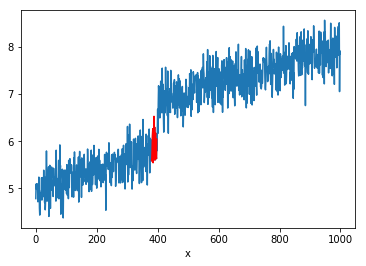

In [643]:
df_subset = df_anom.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_anom.plot(x='x', y='y', legend=False, ax=ax)
df_subset.plot(x='x', y='y',legend=False, ax=ax, color="r")
plt.show()